# Importações

In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, make_scorer, f1_score, roc_auc_score, RocCurveDisplay
from lightgbm import LGBMClassifier
from scipy.stats import randint as sp_randint, uniform


## Dicionário de Dados



| **Variável**                 | **Descrição**                                                                 | **Tipo**             | **Valores Possíveis / Observações**                                   |
|-----------------------------|------------------------------------------------------------------------------|----------------------|------------------------------------------------------------------------|
| `age`                       | Idade do paciente                                                            | Numérica contínua    | Ex: 35                                                                  |
| `sex`                       | Sexo do paciente                                                             | Categórica            | `M` (masculino), `F` (feminino)                                        |
| `on_thyroxine`              | Uso de tiroxina                                                              | Binária              | `t` (sim), `f` (não)                                                   |
| `query_on_thyroxine`        | Suspeita de uso de tiroxina                                                  | Binária              | `t`, `f`                                                               |
| `on_antithyroid_medication` | Uso de medicação antitireoidiana                                             | Binária              | `t`, `f`                                                               |
| `sick`                      | Se o paciente está doente no momento                                         | Binária              | `t`, `f`                                                               |
| `pregnant`                  | Se o paciente está grávida                                                   | Binária              | `t`, `f`                                                               |
| `thyroid_surgery`           | Histórico de cirurgia na tireoide                                           | Binária              | `t`, `f`                                                               |
| `I131_treatment`            | Tratamento com iodo radioativo                                               | Binária              | `t`, `f`                                                               |
| `query_hypothyroid`         | Suspeita de hipotireoidismo                                                  | Binária              | `t`, `f`                                                               |
| `query_hyperthyroid`        | Suspeita de hipertireoidismo                                                 | Binária              | `t`, `f`                                                               |
| `lithium`                   | Uso de lítio                                                                 | Binária              | `t`, `f`                                                               |
| `goitre`                    | Presença de bócio                                                            | Binária              | `t`, `f`                                                               |
| `tumor`                     | Presença de tumor                                                            | Binária              | `t`, `f`                                                               |
| `hypopituitary`             | Diagnóstico de hipopituitarismo                                              | Binária              | `t`, `f`                                                               |
| `psych`                     | Condição psiquiátrica relevante                                              | Binária              | `t`, `f`                                                               |
| `TSH`                       | Hormônio estimulador da tireoide                                             | Numérica contínua    | Ex: 1.3 (μU/mL)                                                        |
| `T3`                        | Triiodotironina total                                                        | Numérica contínua    | Ex: 2.8 (ng/dL)                                                        |
| `TT4`                       | Tiroxina total                                                               | Numérica contínua    | Ex: 120 (μg/dL)                                                        |
| `T4U`                       | Captação de tiroxina livre                                                   | Numérica contínua    | Índice relativo                                                        |
| `FTI`                       | Índice de tiroxina livre (Free Thyroxine Index)                              | Numérica contínua    | Índice relativo                                                        |
| `TBG`                       | Globulina ligadora de tiroxina                                               | Constante / Excluída | Valor constante — removida da modelagem                               |
| `binaryClass`               | Variável alvo (condição tireoidiana ou não)

#Extração dos dados e exploração

Vamos fazer a extração dos dados e sua visualiazação

In [110]:
df = pd.read_csv("/content/Base_M43_Pratique_Hypothyroid.csv", delimiter = ",")
df.head()

,age,sex,on thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,query hypothyroid,...,TT4 measured,TT4,T4U measured,T4U,FTI measured,FTI,TBG measured,TBG,referral source,binaryClass
0,41,F,f,f,f,f,f,f,f,f,...,t,125,t,1.14,t,109,f,?,SVHC,P
1,23,F,f,f,f,f,f,f,f,f,...,t,102,f,?,f,?,f,?,other,P
2,46,M,f,f,f,f,f,f,f,f,...,t,109,t,0.91,t,120,f,?,other,P
3,70,F,t,f,f,f,f,f,f,f,...,t,175,f,?,f,?,f,?,other,P
4,70,F,f,f,f,f,f,f,f,f,...,t,61,t,0.87,t,70,f,?,SVI,P


In [111]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3772 entries, 0 to 3771
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   age                        3772 non-null   object
 1   sex                        3772 non-null   object
 2   on thyroxine               3772 non-null   object
 3   query on thyroxine         3772 non-null   object
 4   on antithyroid medication  3772 non-null   object
 5   sick                       3772 non-null   object
 6   pregnant                   3772 non-null   object
 7   thyroid surgery            3772 non-null   object
 8   I131 treatment             3772 non-null   object
 9   query hypothyroid          3772 non-null   object
 10  query hyperthyroid         3772 non-null   object
 11  lithium                    3772 non-null   object
 12  goitre                     3772 non-null   object
 13  tumor                      3772 non-null   object
 14  hypopitu

Percentual de valores ausentes por coluna

In [112]:
missing = df.isnull().mean().sort_values(ascending=False)
print(missing[missing > 0] * 100)

Series([], dtype: float64)


In [113]:
df['TBG'].unique()

array(['?'], dtype=object)

Vamo remover ausentes e a TBG measured por que é reduntante e a referral source pois apenas indica de onde ou por quem o paciente foi encaminhado

In [114]:
colunas_muitas_ausencias = missing[missing > 0.7].index.tolist()
print("\n Colunas com mais de 70% de ausência:", colunas_muitas_ausencias)

redundantes = ['TBG measured']
print(" Colunas redundantes por ligação com colunas ausentes:", redundantes)


 Colunas com mais de 70% de ausência: []
 Colunas redundantes por ligação com colunas ausentes: ['TBG measured']


In [115]:
to_drop = colunas_muitas_ausencias + redundantes + ['referral source']
df.drop(columns=to_drop, inplace=True)

#Codificação

Como usando o LGBM que utiliza modelo em arvore vamos usar o o label_encoder

In [116]:
label_encoders = {}
for col in df.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

#Análise univariada

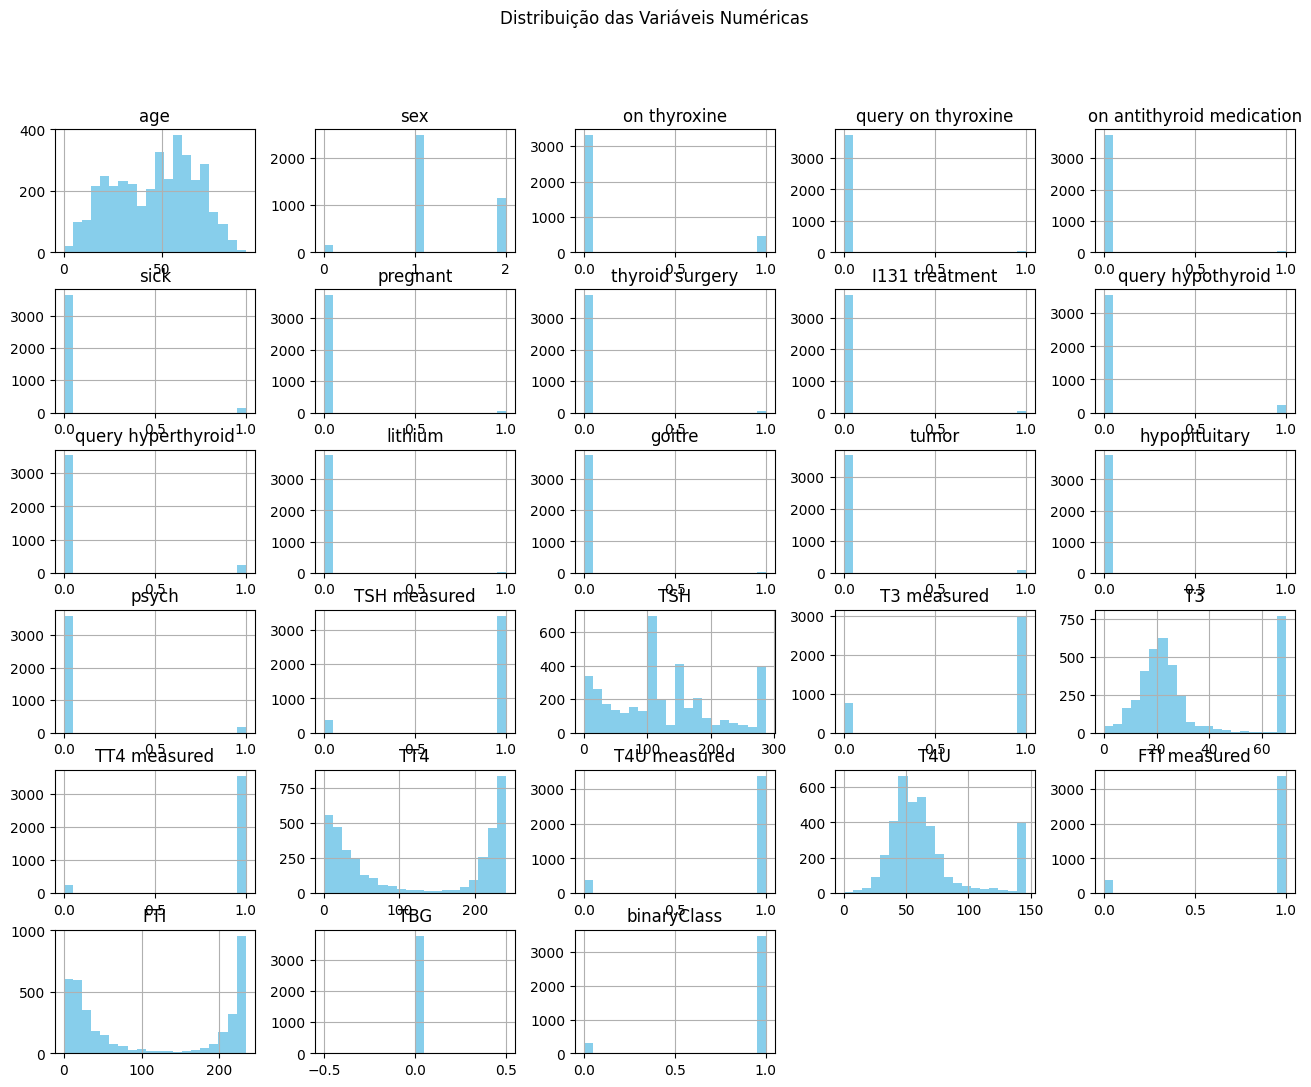

In [117]:
df.hist(bins=20, figsize=(16, 12), color='skyblue')
plt.suptitle("Distribuição das Variáveis Numéricas")
plt.show()

A análise univariada revela um conjunto de dados com características desbalanceadas em variáveis explicativas, e não normalizadas em variáveis contínuas. Isto aponta para a necessidade de: Normalização ou transformação de variáveis contínuas com caudas longas, avaliação do impacto de variáveis binárias muito raras, garantir que a variável alvo continue balanceada ao longo do pipeline de modelagem.

#Análise bivariada

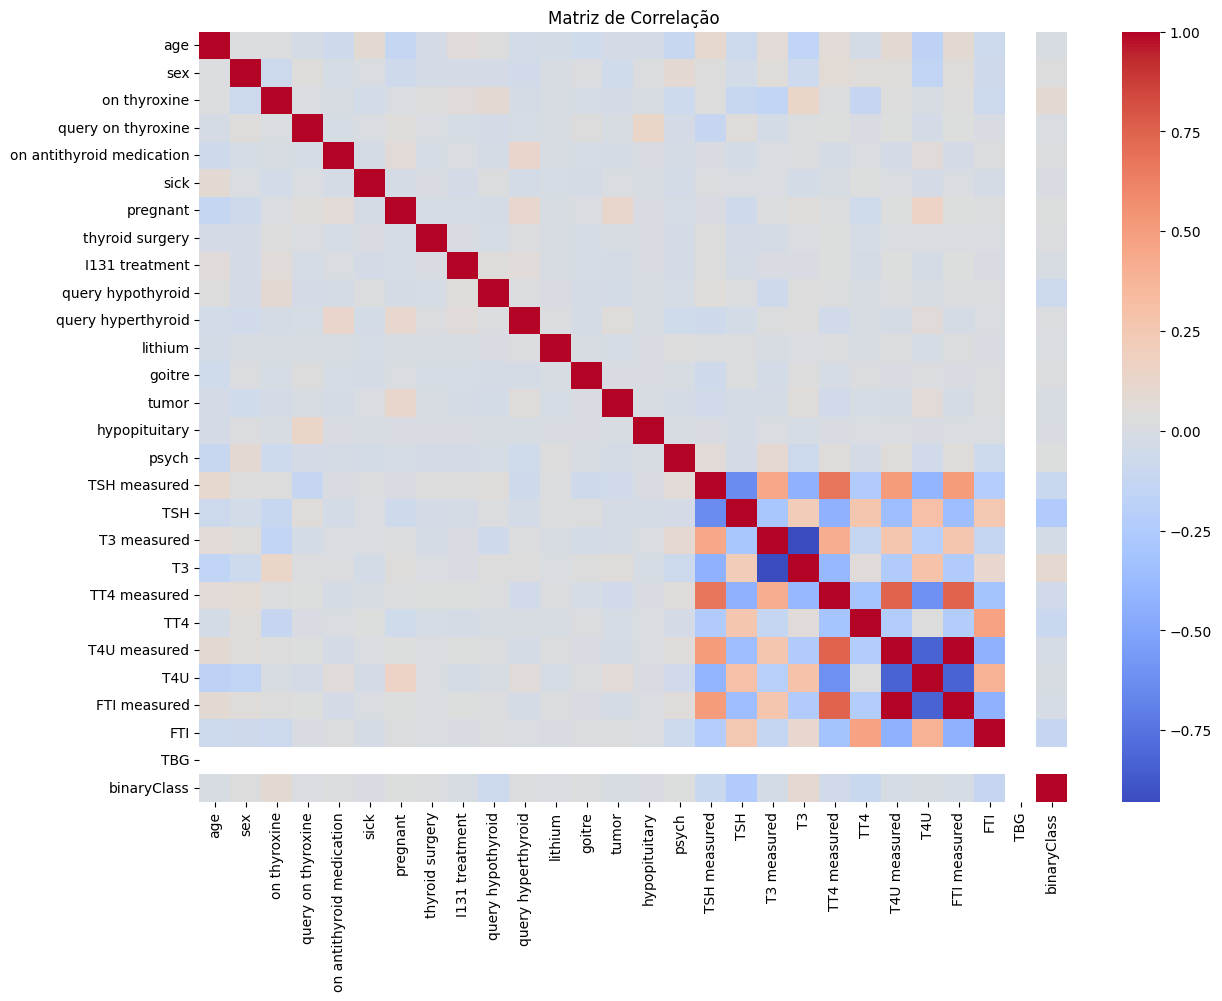

In [118]:
plt.figure(figsize=(14, 10))
sns.heatmap(df.corr(), annot=False, cmap='coolwarm')
plt.title("Matriz de Correlação")
plt.show()

Com base na matriz, podemos:
Priorizar variáveis como TSH, T3, T4, FTI e T4U na modelagem;

Considerar a remoção ou agrupamento de variáveis altamente correlacionadas entre si;

Avaliar o uso de técnicas que lidem com multicolinearidade;

Como usar um modelo em arvore não a necessidade e inicialmente queremos preservar o máximo de dados, depois farei uma analise fazendo isso

In [119]:
corr_target = df.corr()['binaryClass'].sort_values(ascending=False)
print("\n Correlação com a variável alvo:")
print(corr_target)


 Correlação com a variável alvo:
binaryClass                  1.000000
T3                           0.099057
on thyroxine                 0.081060
sex                          0.042815
pregnant                     0.034516
psych                        0.028575
goitre                       0.027575
on antithyroid medication    0.021689
thyroid surgery              0.017633
query hyperthyroid           0.013446
query on thyroxine           0.007448
lithium                      0.005603
hypopituitary                0.004708
sick                         0.001749
I131 treatment              -0.003590
tumor                       -0.003747
T4U                         -0.003889
age                         -0.004863
FTI measured                -0.015431
T4U measured                -0.015901
T3 measured                 -0.032866
TT4 measured                -0.053129
query hypothyroid           -0.086282
TSH measured                -0.095209
TT4                         -0.097274
FTI             

Agora aliminar a redundancia entre as matrizes

In [120]:
corr_matrix = df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_remove_corr = [column for column in upper.columns if any(upper[column] > 0.95)]
print("\n Colunas com alta correlação entre si (>0.95):", to_remove_corr)
df.drop(columns=to_remove_corr, inplace=True)


 Colunas com alta correlação entre si (>0.95): ['FTI measured']


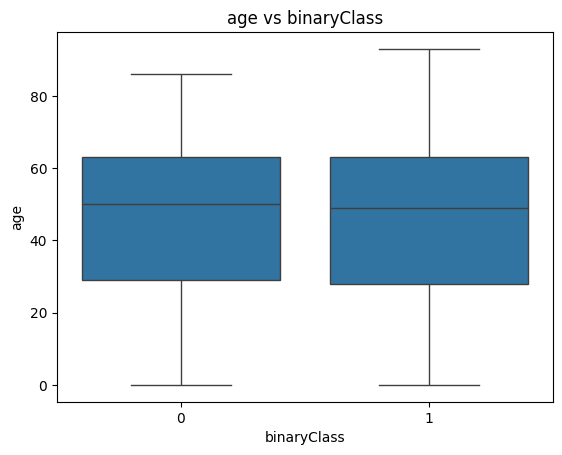

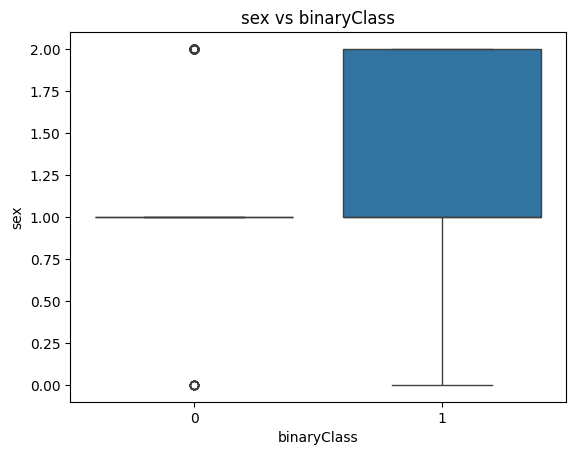

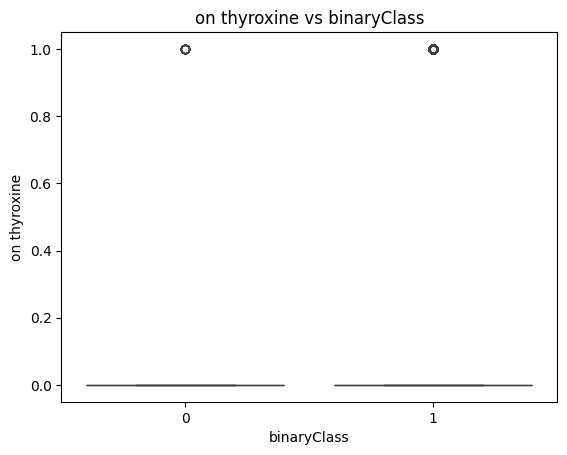

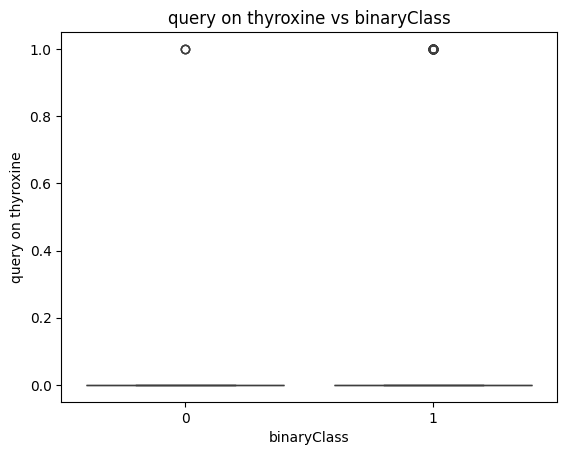

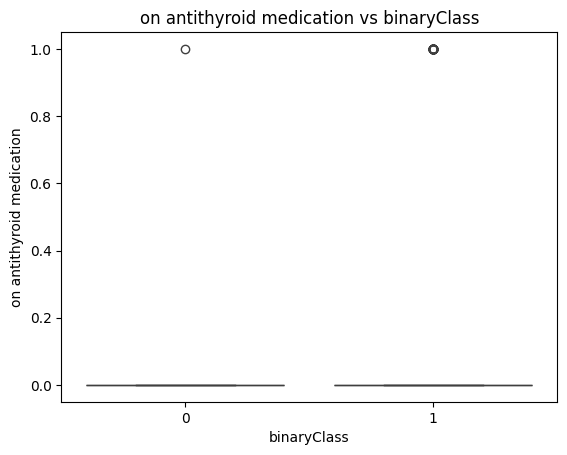

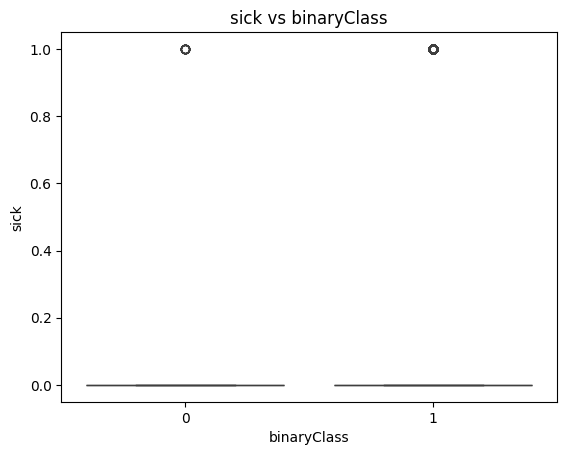

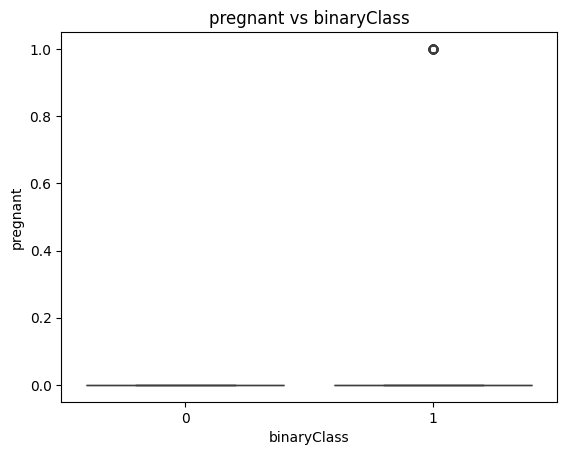

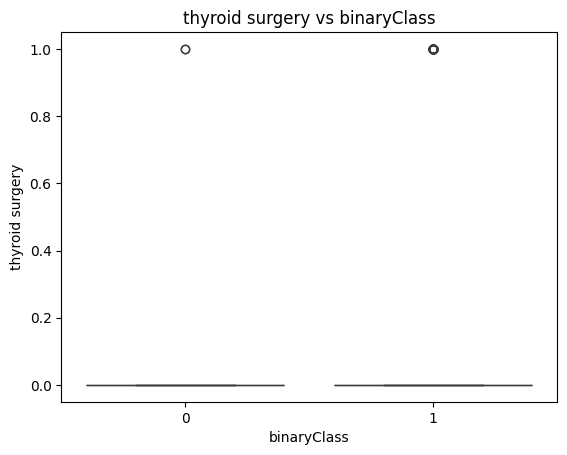

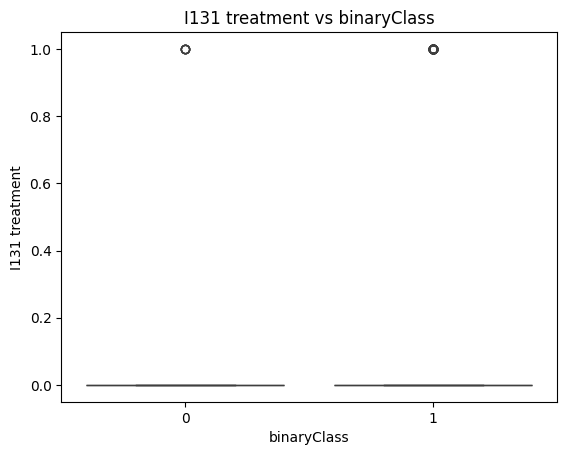

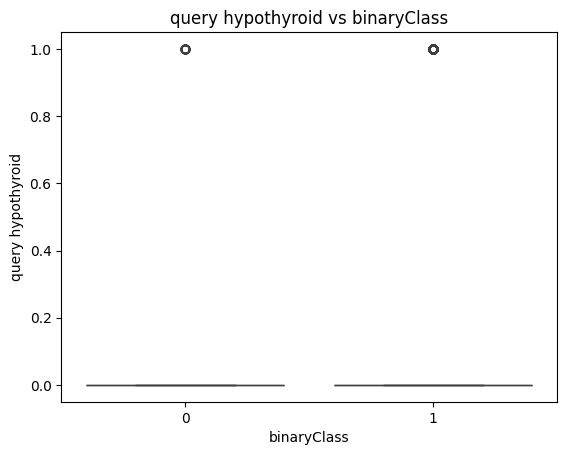

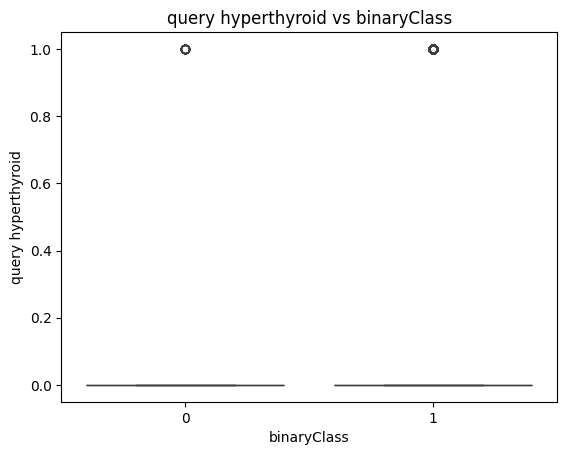

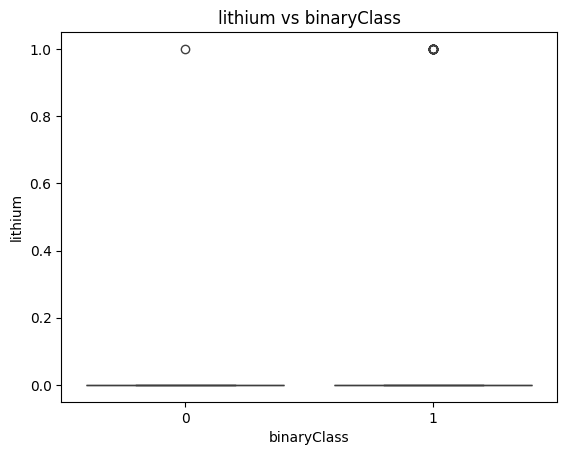

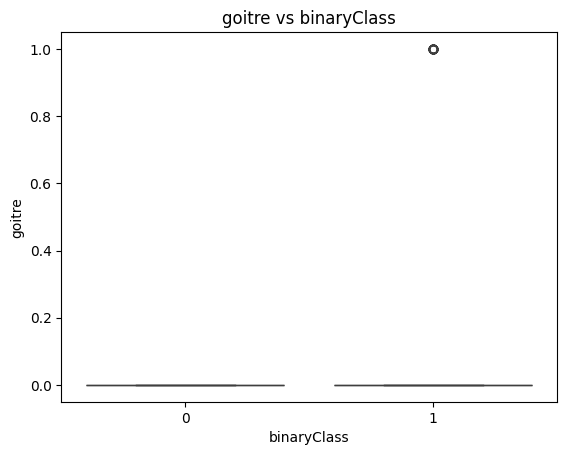

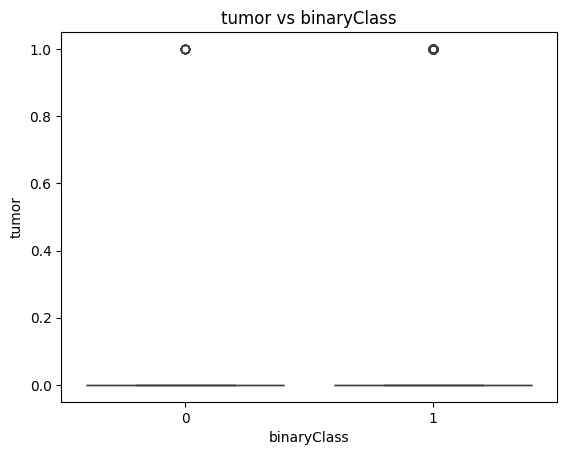

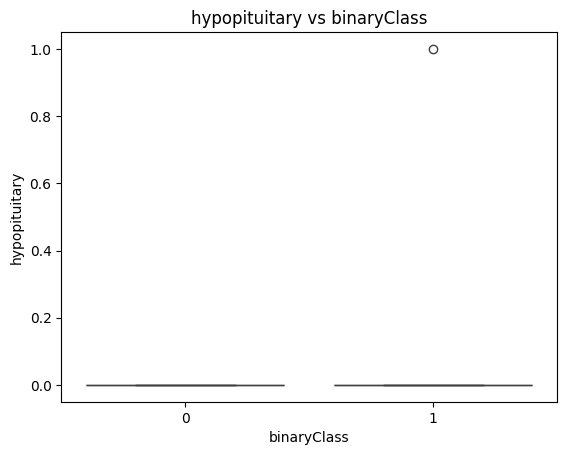

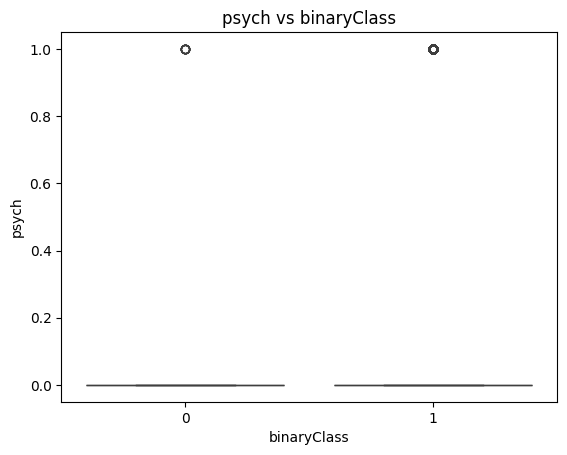

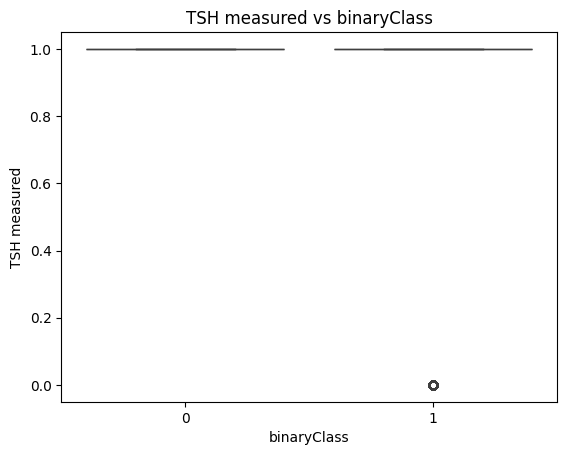

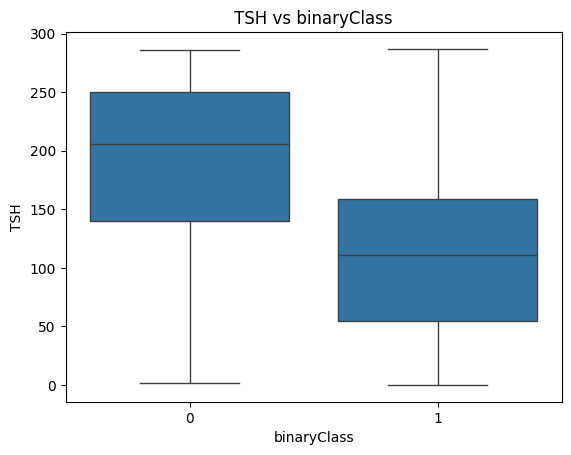

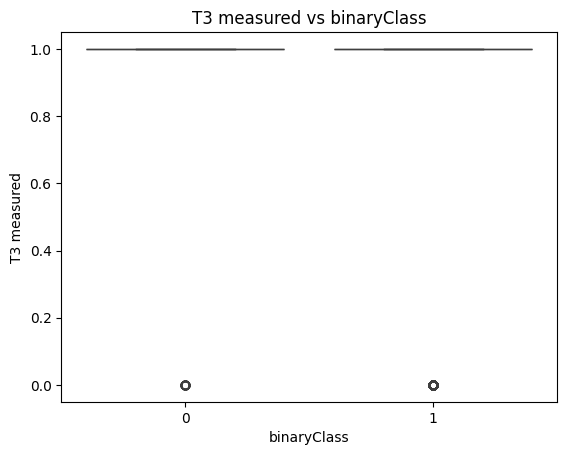

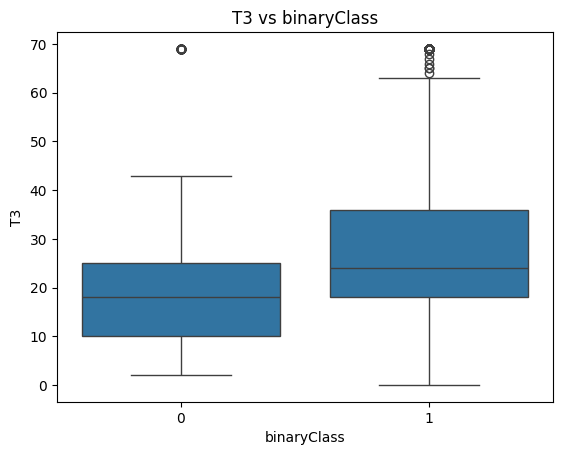

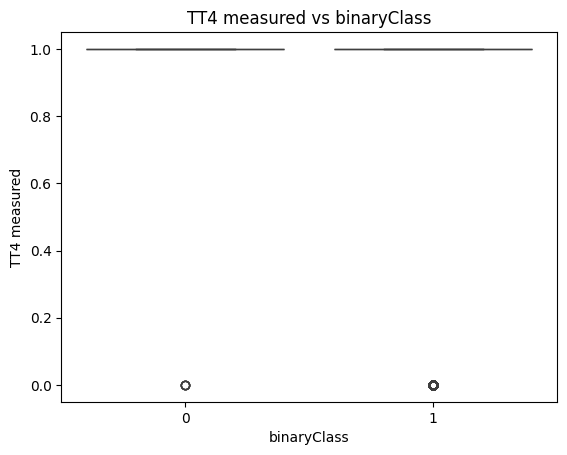

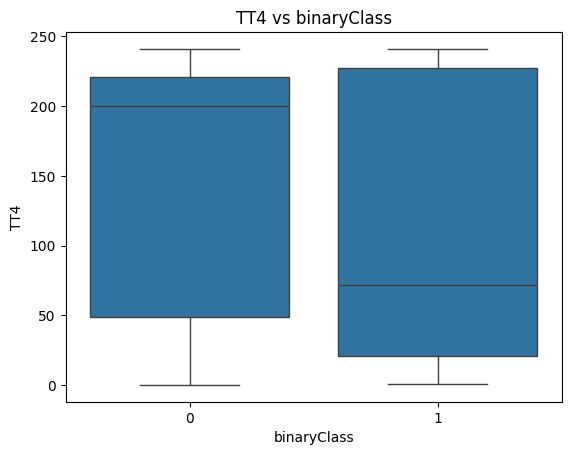

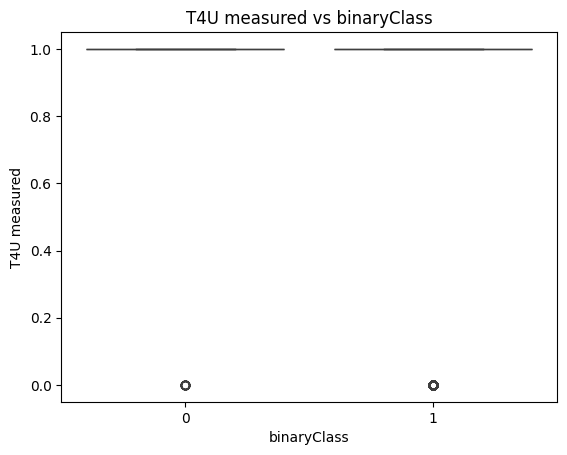

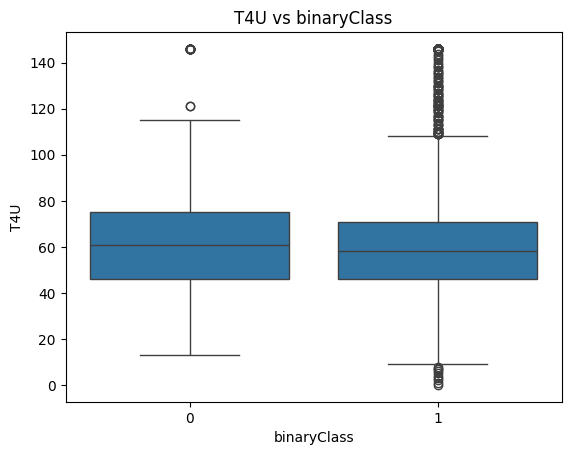

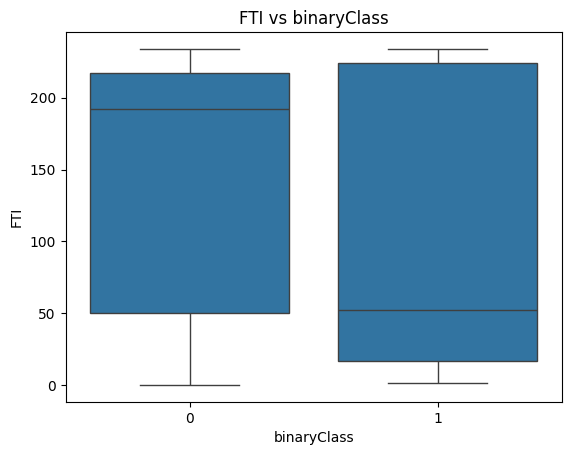

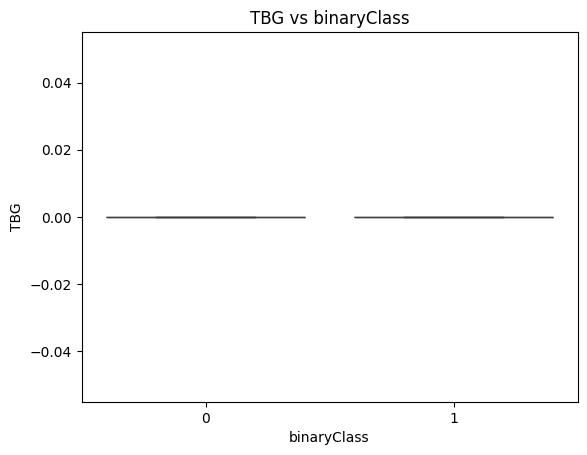

In [121]:
for col in df.drop(columns='binaryClass').columns:
    sns.boxplot(x='binaryClass', y=col, data=df)
    plt.title(f"{col} vs binaryClass")
    plt.show()

Variáveis binárias como on thyroxine, query on thyroxine, on antithyroid medication, sick, pregnant e outras apresentaram distribuição altamente concentrada no valor zero, indicando baixa variabilidade e provável influência limitada individualmente. No entanto, não se descarta a possibilidade de ganho preditivo quando consideradas em conjunto com outras variáveis. A variável sex mostrou uma leve diferença entre as classes, sugerindo algum nível de associação, enquanto age teve distribuição bastante semelhante entre os grupos.

As variáveis laboratoriais foram as que apresentaram maior capacidade discriminativa. Indicadores como T3, TSH, TT4, T4U e FTI demonstraram padrões distintos entre as classes, especialmente com valores mais baixos de TT4 e FTI na classe com condição tireoidiana.Por outro lado, variáveis como TBG, que apresentou valor constante em todos os registros, e as variáveis com pouca variação, tendem a não agregar valor e podem ser descartadas em uma modelagem preditiva.

Em resumo, a análise reforça que os hormônios tireoidianos têm papel central na distinção entre os grupos, enquanto variáveis demográficas e clínicas simples oferecem menor poder discriminativo de forma isolada.



In [122]:
constantes = []
quase_constantes = []

for col in df.columns:
    freq = df[col].value_counts(normalize=True, dropna=False)
    if len(freq) == 1:
        constantes.append(col)
    elif freq.iloc[0] > 0.99:
        quase_constantes.append(col)

print(" Variáveis com valor constante:", constantes)
print(" Variáveis com variação quase nula (>99% iguais):", quase_constantes)

 Variáveis com valor constante: ['TBG']
 Variáveis com variação quase nula (>99% iguais): ['lithium', 'goitre', 'hypopituitary']


In [123]:
constantes_e_quase_constantes = ['TBG', 'lithium', 'goitre', 'hypopituitary']
df.drop(columns=constantes_e_quase_constantes, inplace=True)

#Construção do modelo


Como usaremos um modelo pouco sensivel a outliers não iremos trata-los a priori porem de mostrar relevancia iremos tratar, então vamos balancear

In [124]:
X = df.drop(columns='binaryClass')
y = df['binaryClass']
print("\nDistribuição antes do balanceamento:\n", y.value_counts())


Distribuição antes do balanceamento:
 binaryClass
1    3481
0     291
Name: count, dtype: int64


In [125]:
X_res, y_res = SMOTE(random_state=42).fit_resample(X, y)
print("\nDistribuição após SMOTE:\n", pd.Series(y_res).value_counts())


Distribuição após SMOTE:
 binaryClass
1    3481
0    3481
Name: count, dtype: int64


In [126]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_res)

Agora é a a estapa da padronização e PCA

In [127]:
print("Total:", len(df.columns))

Total: 23


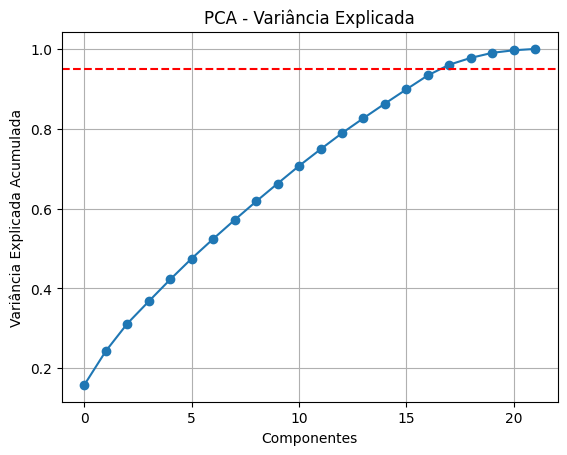

In [128]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_res)

pca = PCA().fit(X_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel("Componentes")
plt.ylabel("Variância Explicada Acumulada")
plt.title("PCA - Variância Explicada")
plt.axhline(0.95, color='red', linestyle='--')
plt.grid(True)
plt.show()

Vamos aplicar o PCA

In [129]:
pca_95 = PCA(n_components=0.95)
X_pca = pca_95.fit_transform(X_scaled)
print(f"\nNúmero de componentes principais para 95% de variância: {pca_95.n_components_}")


Número de componentes principais para 95% de variância: 18


vamos treinar o modelo e definir seus melhores hiperparâmetros

In [130]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_res, test_size=0.2, random_state=42, stratify=y_res)


In [131]:
lgbm = LGBMClassifier(random_state=42)

In [132]:
param_dist = {
    'n_estimators': sp_randint(50, 300),
    'max_depth': sp_randint(3, 10),
    'learning_rate': uniform(0.01, 0.3),
    'num_leaves': sp_randint(20, 150),
    'min_child_samples': sp_randint(10, 100),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5)
}

In [133]:
random_search = RandomizedSearchCV(
    lgbm,
    param_distributions=param_dist,
    n_iter=50,
    scoring='f1',
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)


In [134]:
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2785, number of negative: 2784
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001735 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 5569, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500090 -> initscore=0.000359
[LightGBM] [Info] Start training from score 0.000359
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

RandomizedSearchCV(cv=3, estimator=LGBMClassifier(random_state=42), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fe5740dd8d0>,
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fe5744ee250>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_...
                                        'min_child_samples': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fe575575fd0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fe575183e90>,
                                        'num_leaves': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fe5757fc7d0>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fe575576990>},
                   random_state=42, scoring='f1', verbose=1)

In [135]:
best_lgbm = random_search.best_estimator_
print("\nMelhores hiperparâmetros encontrados:")
print(random_search.best_params_)


Melhores hiperparâmetros encontrados:
{'colsample_bytree': np.float64(0.923330571119153), 'learning_rate': np.float64(0.26689728756342773), 'max_depth': 8, 'min_child_samples': 42, 'n_estimators': 201, 'num_leaves': 135, 'subsample': np.float64(0.5420699824975244)}


#Avaliação do modelo

Avaliação final


 Matriz de Confusão:


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


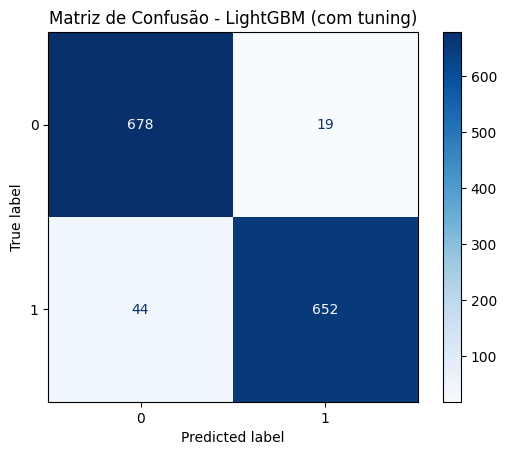


 Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.94      0.97      0.96       697
           1       0.97      0.94      0.95       696

    accuracy                           0.95      1393
   macro avg       0.96      0.95      0.95      1393
weighted avg       0.96      0.95      0.95      1393



In [136]:
y_pred = best_lgbm.predict(X_test)

print("\n Matriz de Confusão:")
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues")
plt.title("Matriz de Confusão - LightGBM (com tuning)")
plt.show()

print("\n Relatório de Classificação:")
print(classification_report(y_test, y_pred))

O modelo LightGBM com tuning demonstrou excelente desempenho na tarefa de classificação, atingindo uma acurácia de 95% com métricas equilibradas entre as classes. A matriz de confusão mostra que o modelo teve baixo número de falsos positivos (19) e falsos negativos (44), com a maioria das previsões corretas para ambas as classes. O f1-score ficou em torno de 0.95 para ambas as classes, indicando que o modelo é eficaz tanto em identificar corretamente os casos positivos quanto em evitar alarmes falsos. Além disso, a média ponderada das métricas reforça que o modelo não está enviesado, lidando bem com possíveis desbalanceamentos. Esses resultados sugerem que o LightGBM está bem ajustado ao problema e se mostra uma alternativa robusta para aplicações práticas. Iremos fazer uma validação cruzada para validar os resultados.

In [137]:
X_cv = X_pca
y_cv = y_res

model = best_lgbm

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

f1_scores = cross_val_score(model, X_cv, y_cv, cv=cv, scoring='f1')

print(" F1-score em cada fold:", np.round(f1_scores, 4))
print(" Média F1-score:", np.mean(f1_scores).round(4))
print(" Desvio padrão:", np.std(f1_scores).round(4))

[LightGBM] [Info] Number of positive: 2784, number of negative: 2785
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001127 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 5569, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499910 -> initscore=-0.000359
[LightGBM] [Info] Start training from score -0.000359
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2785, number of negative: 2785
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002440 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 5570, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2785, number of negative: 2785
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 5570, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


o modelo está performando de forma sólida e consistente, com equilíbrio entre precisão e sensibilidade, sendo confiável para prever novas observações.

Por fim vamos analisar a curva ROC AUC

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 ROC AUC Score: 0.9878


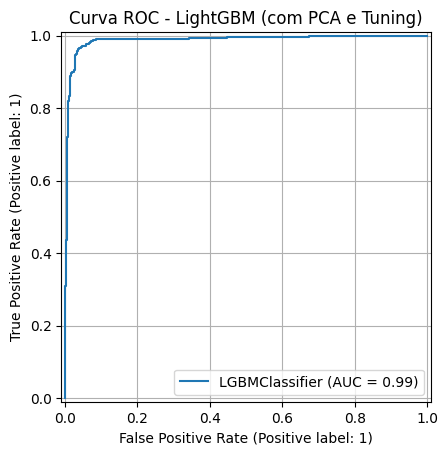

In [138]:
y_prob = best_lgbm.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(y_test, y_prob)
print(f"\n ROC AUC Score: {roc_auc:.4f}")

RocCurveDisplay.from_estimator(best_lgbm, X_test, y_test)
plt.title("Curva ROC - LightGBM (com PCA e Tuning)")
plt.grid(True)
plt.show()

A análise da Curva ROC obtida após o treinamento do modelo LightGBM com redução de dimensionalidade via PCA e ajuste fino de hiperparâmetros demonstra um desempenho notável na classificação das classes-alvo. A curva apresentada no gráfico revela um traçado que se aproxima fortemente do canto superior esquerdo, o que indica que o modelo consegue manter uma alta taxa de verdadeiros positivos enquanto minimiza os falsos positivos. Complementarmente, o valor da área sob a curva foi de 0.9878, reforçando a eficácia do classificador em distinguir corretamente entre as classes positiva e negativa ao longo de diferentes limiares de decisão.  O fato de o modelo ter alcançado essa performance mesmo após a compressão de variáveis pelo PCA demonstra que ele soube preservar as informações mais relevantes, reduzindo o ruído e a complexidade sem sacrificar a capacidade preditiva. Assim, a combinação de SMOTE, PCA e tuning com LightGBM revelou-se uma estratégia muito eficaz para este conjunto de dados.

#Conclusão

O projeto teve como foco a construção de um modelo preditivo capaz de identificar condições relacionadas à tireoide a partir de variáveis clínicas e laboratoriais. Por meio de um pipeline completo, que incluiu análise exploratória, tratamento de dados, balanceamento com SMOTE, redução de dimensionalidade via PCA e modelagem com LightGBM, foi possível atingir um desempenho notável.

Com uma acurácia de 95% e AUC de 0.9878, o modelo demonstrou ser robusto, equilibrado e eficaz para o problema proposto. A análise mostrou que as variáveis hormonais foram as mais relevantes para a predição, enquanto atributos com pouca variabilidade puderam ser descartados sem prejuízo ao desempenho.

A abordagem adotada se mostrou adequada mesmo diante de um dataset desbalanceado e de alta dimensionalidade.